In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale = 1.5)

In [15]:
df = pd.read_csv('https://github.com/EuMentality/datasets/raw/main/taxi_trip.csv')

In [16]:
df.shape

(1458644, 11)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [18]:
# Removing irrelevant trips
latitude_min, latitude_max = 40.700, 40.85
longitude_min, longitude_max = -74.02, -73.93

mask_1 = df['dropoff_latitude'].between(latitude_min, latitude_max)
mask_2 = df['pickup_latitude'].between(latitude_min, latitude_max)
mask_3 = df['dropoff_longitude'].between(longitude_min,longitude_max)
mask_4 = df['pickup_longitude'].between(longitude_min, longitude_max)
mask = mask_1 & mask_2 & mask_3 & mask_4
df = df[mask].reset_index(drop=True)

In [19]:
# drop cheat col
df.drop(['dropoff_datetime', 'id'], axis=1, inplace=True)

In [20]:
# transform target to logarithm for optimizing msle
df.trip_duration = np.log1p(df.trip_duration)

In [21]:
# time col to datetime
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [22]:
# month, weekday, hour of pickup date
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['high_traffic'] = df['pickup_hour'].apply(lambda x: 1 if  8 <= x <= 20 else 0)

In [23]:
# anomaly day
anomaly_days = [pd.to_datetime('2016-01-23'), pd.to_datetime('2016-01-24')]
df['anomaly'] = df.pickup_datetime.between(anomaly_days[0], anomaly_days[1], inclusive='both').astype(int)
df.drop('pickup_datetime', axis=1, inplace=True)

In [24]:
# estimation of the trip distance
meas_ang = 0.506 # 29 градусов = 0.506 радиан
df['diff_latitude'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()*111
df['diff_longitude'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()*80
df['Euclidean'] = (df.diff_latitude**2 + df.diff_longitude**2)**0.5 
df['delta_manh_long'] = (df.Euclidean*np.sin(np.arctan(df.diff_longitude / df.diff_latitude)-meas_ang)).abs()
df['delta_manh_lat'] = (df.Euclidean*np.cos(np.arctan(df.diff_longitude / df.diff_latitude)-meas_ang)).abs()
df['manh_length'] = df.delta_manh_long + df.delta_manh_lat
df.drop(['diff_latitude', 'diff_longitude', 'Euclidean', 'delta_manh_long', 'delta_manh_lat'], axis=1, inplace=True)

In [25]:
# rare categories
df['passenger_count'] = df['passenger_count'].apply(lambda x: -1 if (x in [7,8,9,0]) else x)

In [26]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,high_traffic,anomaly,manh_length
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,3,0,17,1,0,2.006876
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,6,6,0,0,0,2.394278
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,1,1,11,1,0,7.304991
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,4,2,19,1,0,1.930130
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,3,5,13,1,0,1.608787


In [28]:
df.to_csv('taxi_train.csv', sep=';', index=False)

<AxesSubplot:>

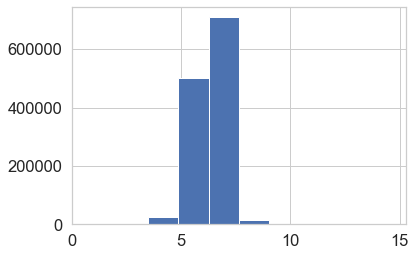

In [14]:
df.trip_duration.hist()

In [13]:
df.head().T

,0,1,2,3,4
id,id2875421,id2377394,id3858529,id3504673,id2181028
vendor_id,2,1,2,2,2
pickup_datetime,2016-03-14 17:24:55,2016-06-12 00:43:35,2016-01-19 11:35:24,2016-04-06 19:32:31,2016-03-26 13:30:55
passenger_count,1,1,1,1,1
pickup_longitude,-73.982155,-73.980415,-73.979027,-74.01004,-73.973053
pickup_latitude,40.767937,40.738564,40.763939,40.719971,40.793209
dropoff_longitude,-73.96463,-73.999481,-74.005333,-74.012268,-73.972923
dropoff_latitude,40.765602,40.731152,40.710087,40.706718,40.78252
store_and_fwd_flag,N,N,N,N,N
trip_duration,6.122493,6.498282,7.661527,6.063785,6.077642


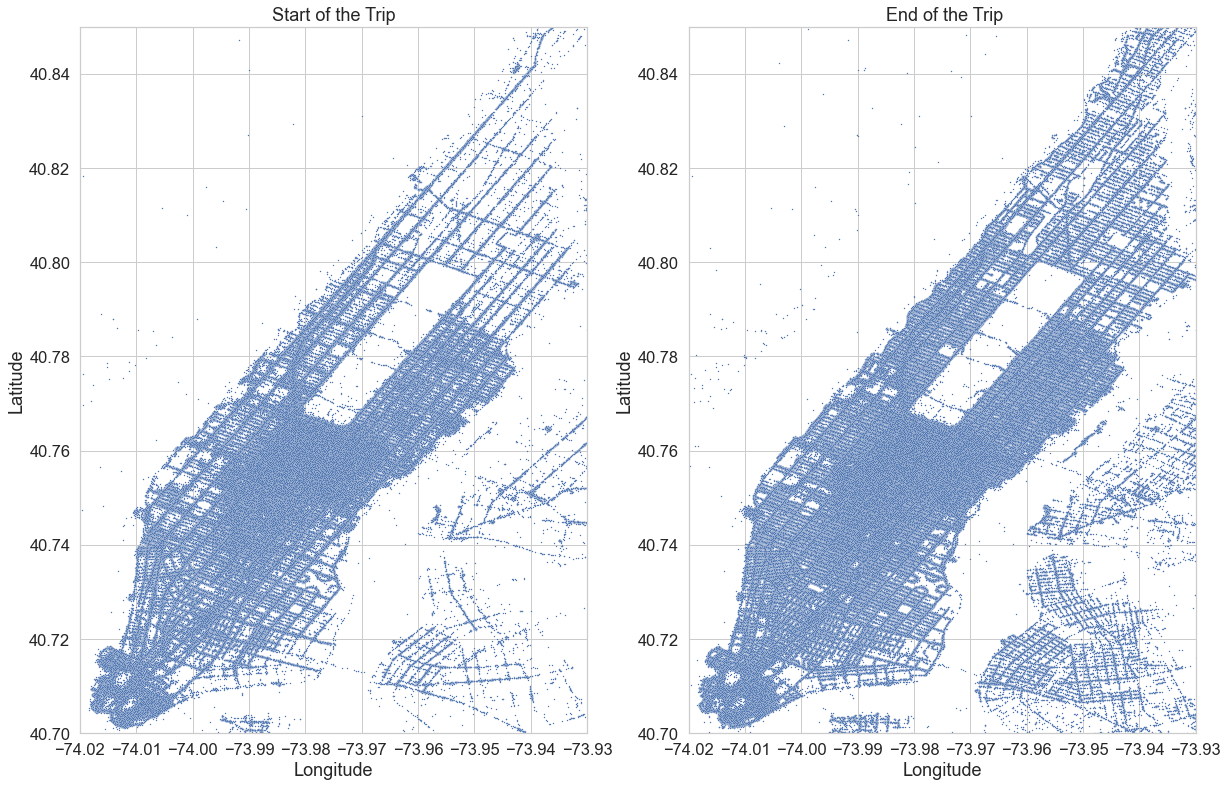

In [12]:
# Scatter Plot for Start/End trip 
fig, axes = plt.subplots(1, 2,figsize=(20, 13))
long_lat_set = [('pickup_longitude', 'pickup_latitude'), ('dropoff_longitude', 'dropoff_latitude')]
scatter_name = ['Start of the Trip', ' End of the Trip']
for k, ((longitude, latitude), ax_name) in enumerate(zip(long_lat_set, scatter_name)):
    sns.scatterplot(x=df[longitude], y=df[latitude], s=2, ax=axes[k])
    axes[k].set_title(ax_name)
    axes[k].set_xlabel('Longitude')
    axes[k].set_ylabel('Latitude')
    axes[k].set_ylim(40.700, 40.85)
    axes[k].set_xlim(-74.02,-73.93)